In [60]:
import gc, math, pickle, datetime, os, random
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters

## Utility functions

In [61]:
#Memory Limitation
def reduce_mem_usage(df, verbose=True):
    """
    :param df: Dataframe with columns unprocessed so they use more memory than needed
    
    :returns:
        df -> Dataframe with lower memory use
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df



In [62]:
def features_engineering(df):
    
    #Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = np.uint8(df["timestamp"].dt.hour)
    df["day"] = np.uint8(df["timestamp"].dt.day)
    df["weekday"] = np.uint8(df["timestamp"].dt.weekday)
    df["month"] = np.uint8(df["timestamp"].dt.month)
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                    "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                    "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                    "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                    "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                    "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                    "2019-01-01"]
    df["is_holiday"] = (df.timestamp.isin(holidays)).astype(int)
     
    
    # Remove Columns
    #Dropping the floor count as it contains more than 80% missing data
    drop = ["timestamp","floor_count"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [63]:
SEED = 5

## Download  data

In [64]:
train = pd.read_csv('ashrae-energy-prediction/train.csv')
test = pd.read_csv('ashrae-energy-prediction/test.csv')
weather_train= pd.read_csv('ashrae-energy-prediction/weather_train.csv')
weather_test = pd.read_csv('ashrae-energy-prediction/weather_test.csv')
meta = pd.read_csv('ashrae-energy-prediction/building_metadata.csv')

In [65]:
#Reduce memory
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
weather_train = reduce_mem_usage(weather_train)
weather_test = reduce_mem_usage(weather_test)
meta= reduce_mem_usage(meta)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [7]:
def description(df):
    " function "
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values
    return summary

In [8]:
description(train)

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,building_id,int16,0,1449,0,1,2
1,meter,int8,0,4,0,0,0
2,timestamp,object,0,8784,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
3,meter_reading,float32,0,1688175,0.0,0.0,0.0


In [9]:
description(weather_train)

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,site_id,int8,0,16,0,0,0
1,timestamp,object,0,8784,2016-01-01 00:00:00,2016-01-01 01:00:00,2016-01-01 02:00:00
2,air_temperature,float16,55,619,25.0,24.40625,22.796875
3,cloud_coverage,float16,69173,10,6.0,NaN,2.0
4,dew_temperature,float16,113,522,20.0,21.09375,21.09375
5,precip_depth_1_hr,float16,50289,128,NaN,-1.0,0.0
6,sea_level_pressure,float16,10618,133,1019.5,1020.0,1020.0
7,wind_direction,float16,6268,43,0.0,70.0,0.0
8,wind_speed,float16,304,58,0.0,1.5,0.0


In [10]:
description(meta)

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,site_id,int8,0,16,0,0,0
1,building_id,int16,0,1449,0,1,2
2,primary_use,object,0,16,Education,Education,Education
3,square_feet,int32,0,1397,7432,2720,5376
4,year_built,float16,774,116,2008.0,2004.0,1991.0
5,floor_count,float16,1094,18,NaN,NaN,NaN


In [68]:
train = train.merge(meta, on='building_id', how='left')
train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test =test.merge(meta, on='building_id', how='left')
test =test.merge(weather_test, on=['site_id', 'timestamp'], how='left')

In [12]:
del weather_test
del weather_train
del meta
gc.collect()

22

In [13]:
train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,NaN,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875


In [14]:
print(train.shape)
print(test.shape)

(20216100, 16)
(41697600, 16)


## Preprocessing

In [15]:
#he site 0 electric meter readings are in kBTU
train.loc[(train.site_id == 0) & (train.meter==0), 'meter_reading'] =  train.loc[(train.site_id == 0) & (train.meter==0), 'meter_reading'] * 0.2931

### Plot meter reading for each building 

In [16]:
b_id_list=train.building_id.unique()

In [17]:
import plotly.graph_objects as go
from ipywidgets import interact, widgets
import numpy as np


@interact(n=b_id_list)
def plott(n):
  s=train[(train.building_id == n) & (train.meter ==0 )]
  fig = go.Figure(data=go.Scatter(x=s['timestamp'], y=s['meter_reading']))
  fig.show()

interactive(children=(Dropdown(description='n', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [18]:
import plotly.graph_objects as go
from ipywidgets import interact, widgets
import numpy as np


@interact(n=b_id_list)
def plott(n):
  s=train[(train.building_id == n) & (train.meter ==1 )]
  fig = go.Figure(data=go.Scatter(x=s['timestamp'], y=s['meter_reading']))
  fig.show()

interactive(children=(Dropdown(description='n', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [19]:
import plotly.graph_objects as go
from ipywidgets import interact, widgets
import numpy as np


@interact(n=b_id_list)
def plott(n):
  s=train[(train.building_id == n) & (train.meter ==2 )]
  fig = go.Figure(data=go.Scatter(x=s['timestamp'], y=s['meter_reading']))
  fig.show()

interactive(children=(Dropdown(description='n', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [20]:
import plotly.graph_objects as go
from ipywidgets import interact, widgets
import numpy as np


@interact(n=b_id_list)
def plott(n):
  s=train[(train.building_id == n) & (train.meter ==3)]
  fig = go.Figure(data=go.Scatter(x=s['timestamp'], y=s['meter_reading']))
  fig.show()

interactive(children=(Dropdown(description='n', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [21]:
# #ploter meter_reading dans toutes les sites
# import matplotlib.pyplot 
# def plot_train(building_id):
#     meters = train[train['building_id'] == building_id].meter.nunique()
#     for meter in range(meters):
#         fig, ax = plt.subplots()
#         plt.title(f'Building {building_id} Meter {meter}')
#         ax2 = ax.twinx()
#         idx = (train['building_id'] == building_id) & (train['meter'] == meter)
#         dates = matplotlib.dates.date2num(train.loc[idx, 'timestamp'])
#         ax2.plot_date(dates, train.loc[idx, 'meter_reading'], '-', label='meter_reading')
#         ax2.legend()
#         plt.show()
#         return fig

In [22]:
# for b_id in b_id_list:
#     plot_train(b_id)

### Remove outliers

In [23]:
# using plots we detected outliers
train = train.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-21")')
train = train.query('not (building_id == 1099 & meter == 2 & meter_reading  > 30000)')
train = train.query('not (building_id == 7 & meter == 1 & timestamp <= "2016-11-29" & timestamp >= "2016-11-03")')
train = train.query('not (building_id == 954 & timestamp <= "2016-08-09")')
train = train.query('not (building_id == 783 & meter == 2 & timestamp <= "2016-12-10")')
train = train.query('not (building_id == 1250 & meter == 2 & timestamp <= "2016-12-22")')
train = train.query('not (building_id == 1250 & meter == 0 & meter_reading == 0)')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id <= 1280 & building_id >= 1275 & meter == 0 )')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id <= 1300 & building_id >= 1294 & meter == 0 )')
train = train.query('not (building_id == 1130 & meter == 1 & timestamp < "2016-10-01")') 
train = train.query('not (building_id == 1303 & meter == 2 & timestamp < "2016-06-07")') 
train = train.query('not (building_id == 1303 & meter == 0 & meter_reading < 400)')
train = train.query('not (building_id == 1238 & meter == 0 & meter_reading < 1)') 
train = train.query('not (building_id == 1238 & meter == 2 & meter_reading < 1)') 
train = train.query('not (building_id == 1427 & meter == 2 & meter_reading < 1)') 
train = train.query('not (building_id == 1425 & meter == 2 & meter_reading < 1)') 
train = train.query('not (building_id == 1392 & meter == 2 & meter_reading < 100)') 
train = train.query('not (building_id == 1391 & meter == 2 & meter_reading < 10)')
train = train.query('not (building_id == 1383 & meter == 2 & meter_reading < 10)')
train = train.query('not (building_id == 1383 & meter == 0 & meter_reading < 10)')
train = train.query('not (building_id == 1382 & meter == 2 & meter_reading < 10)')
train = train.query('not (building_id == 1323 & meter == 0 & meter_reading < 1)') 
train = train.query('not (building_id == 1322 & meter == 0 & meter_reading < 1)') 
train = train.query('not (building_id == 1321 & meter == 0 & meter_reading < 1)') 
train = train.query('not (building_id == 1320 & meter == 0 & meter_reading < 1)') 
train = train.query('not (building_id == 1317 & meter == 0 & meter_reading < 1)') 
train = train.query('not (building_id == 1301 & meter == 0 & meter_reading < 1)') 
train = train.query('not (building_id == 1288 & meter == 0 & meter_reading < 1)') 
train = train.query('not (building_id == 1287 & meter == 2 & meter_reading < 1)') 
train = train.query('not (building_id == 1285 & meter == 0 & meter_reading < 1)') 
train = train.query('not (building_id == 1284 & meter == 2 & meter_reading < 1)') 
train = train.query('not (building_id == 1233 & meter == 0 & meter_reading < 1)') 
train = train.query('not (building_id == 1234 & meter == 0 & meter_reading < 1)') 
train = train.query('not (building_id == 1246 & meter == 0 & meter_reading < 1)')
train = train.query('not (building_id == 1246 & meter == 1 & timestamp < "2016-03-07")')
train = train.query('not (building_id == 1246 & meter == 3 & timestamp < "2016-03-07")')
train = train.query('not (building_id == 1319 & meter == 0 & meter_reading < 1)')
train = train.query('not (building_id == 1302  & timestamp > "2016-09-28" & timestamp < "2016-10-21")')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id == 1300 & meter == 1 )')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id == 1300 & meter == 2 )')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id == 1299 & meter == 2 )')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id == 1298 & meter == 2 )')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id == 1297)')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id == 1296)')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id == 1295)')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id == 1294)')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id == 1293)')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id == 1292)')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id == 1291)')
train = train.query('not (timestamp >= "2016-07-06 23:00:00" & timestamp <= "2016-08-12 23:00:00" & building_id == 1288 & meter == 1)')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id == 1276 & meter == 3)')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id == 1275 & meter == 3)')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id == 1272)')
train = train.query('not (timestamp >= "2016-08-21 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id == 1264)')
train = train.query('not (timestamp >= "2016-11-09 23:00:00" & timestamp <= "2016-11-21 23:00:00" & building_id == 1263 & meter == 1)')
train = train.query('not (timestamp >= "2016-11-09 23:00:00" & timestamp <= "2016-11-21 23:00:00" & building_id == 1263 & meter == 2)')
train = train.query('not (timestamp >= "2016-08-20 23:00:00" & timestamp <= "2016-09-05 23:00:00" & building_id == 1252 & meter == 3)')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id == 1223)')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id == 1225)')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id == 1226)')
train = train.query('not (timestamp >= "2016-06-22 23:00:00" & timestamp <= "2016-08-31 23:00:00" & building_id == 1232 & (meter == 1 or meter == 3))')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id == 1233 )')
train = train.query('not (timestamp >= "2016-09-27 23:00:00" & timestamp <= "2016-10-20 23:00:00" & building_id == 1234 )')
train = train.query('not (meter == 3 & timestamp >= "2016-04-03 23:00:00" & timestamp <= "2016-05-09 23:00:00" & building_id == 1235 )')
train = train.query('not (timestamp >= "2016-04-20 23:00:00" & timestamp <= "2016-05-02 23:00:00" & building_id == 1240 )')
train = train.query('not (meter == 3 & timestamp >= "2016-04-03 23:00:00" & timestamp <= "2016-05-06 23:00:00" & building_id == 1244 )')
train = train.query('not (meter == 2 & timestamp >= "2016-10-18 23:00:00" & timestamp <= "2016-11-08 23:00:00" & building_id == 1243 )')
train = train.query('not (meter == 0 & timestamp >= "2016-07-13 00:00:00" & timestamp <= "2016-11-20 00:00:00" & building_id == 1241 )')
train = train.query('not (meter == 0 & timestamp >= "2016-09-14 00:00:00" & timestamp <= "2016-09-30 00:00:00" & building_id == 1232 )')
train = train.query('not (meter == 0 & timestamp >= "2016-07-13 00:00:00" & timestamp <= "2016-11-20 00:00:00" & building_id == 1241 )')
train = train.query('not (meter == 0 & timestamp >= "2016-01-03 00:00:00" & timestamp <= "2016-03-09 00:00:00" & building_id == 1234 )')
train = train.query('not (meter == 0 & timestamp >= "2016-01-03 00:00:00" & timestamp <= "2016-03-09 00:00:00" & building_id == 1233 )')
train = train.query('not (meter == 0 & timestamp >= "2016-09-14 00:00:00" & timestamp <= "2016-10-01 00:00:00" & building_id == 1232 )')
train = train.query('not (meter == 3 &  timestamp <= "2016-02-25 00:00:00" & building_id == 1227 )')
train = train.query('not (meter == 1 & timestamp >= "2016-08-25 00:00:00" & timestamp <= "2016-10-01 00:00:00" & building_id == 1226 )')
train = train.query('not (meter == 1 & timestamp >= "2016-08-25 00:00:00" & timestamp <= "2016-10-01 00:00:00" & building_id == 1225 )')
train = train.query('not (meter == 3 & timestamp <= "2016-02-26 00:00:00" & building_id == 1227 )')
train = train.query('not (meter == 2 & timestamp <= "2016-02-15 00:00:00" & building_id == 1189 )')
train = train.query('not (meter == 2 & timestamp <= "2016-02-11 00:00:00" & building_id == 1176 )')
train = train.query('not (meter == 1 & timestamp >= "2016-09-01 00:00:00" & timestamp <= "2016-09-22 00:00:00" & building_id == 1226 )')
train = train.query('not (meter == 1 & timestamp >= "2016-09-01 00:00:00" & timestamp <= "2016-09-22 00:00:00" & building_id == 1225 )')
train = train.query('not (meter == 0 & timestamp <= "2016-08-04 00:00:00"& building_id == 1169 )')
train = train.query('not (meter == 0 & timestamp <= "2016-01-21 00:00:00"& building_id == 1153 )')
train = train.query('not (meter == 0 & timestamp <= "2016-09-08 00:00:00"& building_id == 1094 )')
train = train.query('not (meter == 0 & timestamp <= "2016-10-25 00:00:00"& building_id == 1073 )')


In [24]:
train=features_engineering(train)

### Imputing missing values


In [25]:

train[['year_built','air_temperature','dew_temperature','cloud_coverage','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']]=train[['year_built','air_temperature','dew_temperature','cloud_coverage','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']].astype(np.float32)

cc_fill=train.groupby(['site_id','day','month'])['cloud_coverage'].median().reset_index()
cc_fill.rename(columns={'cloud_coverage':'cc_filler'},inplace=True)
cc_fill['cc_filler'].fillna(method='ffill',inplace=True)
train=train.merge(cc_fill,how='left',on=['site_id','day','month'])
train['cloud_coverage'].fillna(train['cc_filler'],inplace=True)
train.drop(labels=['cc_filler'],axis=1,inplace=True)


wd_fill=train.groupby(['site_id','day','month'])['wind_direction'].median().reset_index()
wd_fill.rename(columns={'wind_direction':'wind_direction_filler'},inplace=True)
train=train.merge(wd_fill,how='left',on=['site_id','day','month'])
train['wind_direction'].fillna(train['wind_direction_filler'],inplace=True)
train.drop(labels=['wind_direction_filler'],axis=1,inplace=True)

at_fill=train.groupby(['site_id','day','month'])['air_temperature'].median().reset_index()
at_fill.rename(columns={'air_temperature':'air_temperature_filler'},inplace=True)
train=train.merge(at_fill,how='left',on=['site_id','day','month'])
train['air_temperature'].fillna(train['air_temperature_filler'],inplace=True)
train.drop(labels=['air_temperature_filler'],axis=1,inplace=True)

dt_fill=train.groupby(['site_id','day','month'])['dew_temperature'].median().reset_index()
dt_fill.rename(columns={'dew_temperature':'dew_temperature_filler'},inplace=True)
train=train.merge(dt_fill,how='left',on=['site_id','day','month'])
train['dew_temperature'].fillna(train['dew_temperature_filler'],inplace=True)
train.drop(labels=['dew_temperature_filler'],axis=1,inplace=True)

ws_fill=train.groupby(['site_id','day','month'])['wind_speed'].median().reset_index()
ws_fill.rename(columns={'wind_speed':'wind_speed_filler'},inplace=True)
train=train.merge(ws_fill,how='left',on=['site_id','day','month'])
train['wind_speed'].fillna(train['wind_speed_filler'],inplace=True)
train.drop(labels=['wind_speed_filler'],axis=1,inplace=True)

slp_fill=train.groupby(['site_id','day','month'])['sea_level_pressure'].median().reset_index()
slp_fill.rename(columns={'sea_level_pressure':'slp_filler'},inplace=True)
slp_fill.fillna(method='ffill',inplace=True)
train=train.merge(slp_fill,how='left',on=['site_id','day','month'])
train['sea_level_pressure'].fillna(train['slp_filler'],inplace=True)
train.drop(labels=['slp_filler'],axis=1,inplace=True)

pd_fill=train.groupby(['site_id','day','month'])['precip_depth_1_hr'].median().reset_index()
pd_fill.rename(columns={'precip_depth_1_hr':'pd_filler'},inplace=True)
pd_fill['pd_filler'].fillna(method='ffill',inplace=True)
train=train.merge(pd_fill,how='left',on=['site_id','day','month'])
train['precip_depth_1_hr'].fillna(train['pd_filler'],inplace=True)
train.drop(labels=['pd_filler'],axis=1,inplace=True)

yb_fill=train.groupby(['site_id','day','month'])['year_built'].median().reset_index()
yb_fill.rename(columns={'year_built':'yb_filler'},inplace=True)
yb_fill['yb_filler'].fillna(method='ffill',inplace=True)
train=train.merge(yb_fill,how='left',on=['site_id','day','month'])
train['year_built'].fillna(train['yb_filler'],inplace=True)
train.drop(labels=['yb_filler'],axis=1,inplace=True)





In [26]:
# Feature_with_NA = train.train.loc[:, ['floor_count','air_temperature', 'cloud_coverage', 'dew_temperature',
#                       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction','wind_speed']]
# for i in Feature_with_NA.columns:
#     train[i].fillna(train[i].median(), inplace = True)
# for i in Feature_with_NA.columns:
#     test[i].fillna(test[i].median(), inplace = True)

In [27]:
description(train)

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,building_id,int16,0,1449,105.000000,106.000000,106.000000
1,meter,int8,0,4,0.000000,0.000000,3.000000
2,meter_reading,float32,0,1740277,23.303600,0.374600,0.000000
3,site_id,int8,0,16,1.000000,1.000000,1.000000
4,primary_use,int64,0,16,0.000000,0.000000,0.000000
5,square_feet,int32,0,1397,50623.000000,5374.000000,5374.000000
6,year_built,float32,0,123,1960.000000,1960.000000,1960.000000
7,air_temperature,float32,0,639,3.800781,3.800781,3.800781
8,cloud_coverage,float32,0,13,0.000000,0.000000,0.000000
9,dew_temperature,float32,0,539,2.400391,2.400391,2.400391


In [29]:
train

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday,month,is_holiday
0,105,0,23.303600,1,0,50623,1960.0,3.800781,0.0,2.400391,0.0,1021.0,240.0,3.099609,0,1,4,1,1
1,106,0,0.374600,1,0,5374,1960.0,3.800781,0.0,2.400391,0.0,1021.0,240.0,3.099609,0,1,4,1,1
2,106,3,0.000000,1,0,5374,1960.0,3.800781,0.0,2.400391,0.0,1021.0,240.0,3.099609,0,1,4,1,1
3,107,0,175.184006,1,0,97532,2005.0,3.800781,0.0,2.400391,0.0,1021.0,240.0,3.099609,0,1,4,1,1
4,108,0,91.265297,1,0,81580,1913.0,3.800781,0.0,2.400391,0.0,1021.0,240.0,3.099609,0,1,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19740579,1444,0,8.750000,15,1,19619,1914.0,1.700195,2.0,-5.601562,-1.0,1008.5,180.0,8.796875,23,31,5,12,0
19740580,1445,0,4.825000,15,0,4298,1963.0,1.700195,2.0,-5.601562,-1.0,1008.5,180.0,8.796875,23,31,5,12,0
19740581,1446,0,0.000000,15,1,11265,1997.0,1.700195,2.0,-5.601562,-1.0,1008.5,180.0,8.796875,23,31,5,12,0
19740582,1447,0,159.574997,15,4,29775,2001.0,1.700195,2.0,-5.601562,-1.0,1008.5,180.0,8.796875,23,31,5,12,0


In [30]:
# Take lof of target variable
train_y = np.log1p(train['meter_reading'])
train_x = train.drop('meter_reading', axis=1)
train_x.head()

,building_id,meter,site_id,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday,month,is_holiday
0,105,0,1,0,50623,1960.0,3.800781,0.0,2.400391,0.0,1021.0,240.0,3.099609,0,1,4,1,1
1,106,0,1,0,5374,1960.0,3.800781,0.0,2.400391,0.0,1021.0,240.0,3.099609,0,1,4,1,1
2,106,3,1,0,5374,1960.0,3.800781,0.0,2.400391,0.0,1021.0,240.0,3.099609,0,1,4,1,1
3,107,0,1,0,97532,2005.0,3.800781,0.0,2.400391,0.0,1021.0,240.0,3.099609,0,1,4,1,1
4,108,0,1,0,81580,1913.0,3.800781,0.0,2.400391,0.0,1021.0,240.0,3.099609,0,1,4,1,1


In [31]:
del train
gc.collect()

88

##  LGBM 

In [32]:
# Train and Validation splits
test_size = 0.20
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=test_size)

In [33]:
  lgb_params = {
                    'objective':'regression',
                    'boosting_type':'gbdt',
                    'metric':'rmse',
                    'n_jobs':-1,
                    'learning_rate':0.07,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.5,
                    'n_estimators':8500,
                    'max_bin':255,
                    'verbose':1,
                    'seed': SEED,
                    'early_stopping_rounds':3500, 
                } 

In [34]:
X_train

,building_id,meter,site_id,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday,month,is_holiday
2704931,1152,2,13,6,118858,1964.0,0.600098,8.0,-5.601562,0.0,1020.0,220.0,2.099609,1,23,1,2,0
4081175,862,0,8,7,27640,1964.0,17.796875,4.0,9.398438,0.0,1026.0,110.0,4.101562,1,23,2,3,0
4231848,489,0,3,0,85039,1925.0,9.398438,4.0,0.600098,0.0,1020.0,330.0,7.699219,5,26,5,3,0
4937342,720,0,5,0,18202,1919.0,9.000000,0.0,5.000000,0.0,1013.5,330.0,0.500000,19,8,4,4,0
615060,411,0,3,1,6139,1960.5,6.699219,6.0,-7.199219,0.0,1006.5,210.0,6.699219,19,12,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437606,1170,0,13,6,59476,1964.0,-7.199219,2.0,-13.296875,0.0,1020.5,360.0,2.099609,8,17,2,2,0
14672864,959,2,9,0,128536,1964.0,23.296875,0.0,13.296875,0.0,1016.0,100.0,2.099609,0,2,6,10,0
1298738,1076,0,13,4,117054,1964.0,-2.199219,8.0,-3.900391,0.0,1008.0,120.0,1.500000,20,25,0,1,0
18819650,1267,0,14,0,138977,1964.0,-6.101562,0.0,-17.203125,0.0,1014.5,330.0,6.199219,17,15,3,12,0


In [35]:
del train_x
del train_y

gc.collect()

22

In [36]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val)
gbm = lgb.train(lgb_params,
            lgb_train,
            num_boost_round=5000,
            valid_sets=(lgb_train, lgb_eval),
            verbose_eval = 50
           )

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning:

Found `n_estimators` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.207885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1577
[LightGBM] [Info] Number of data points in the train set: 15792467, number of used features: 18
[LightGBM] [Info] Start training from score 4.204719
Training until validation scores don't improve for 3500 rounds
[50]	training's rmse: 1.04002	valid_1's rmse: 1.04057
[100]	training's rmse: 0.894671	valid_1's rmse: 0.895708
[150]	training's rmse: 0.837401	valid_1's rmse: 0.838511
[200]	training's rmse: 0.79808	valid_1's rmse: 0.799481
[250]	training's rmse: 0.771172	valid_1's rmse: 0.772965
[300]	training's rmse: 0.749164	valid_1's rmse: 0.751395
[350]	training's rmse: 0.734237	valid_1's rmse: 0.736944
[400]	training's rmse: 0.720669	valid_1's rmse: 0.723825
[450]	training's rmse: 0.708002	valid_1's rmse: 0.71166
[500]	training's 

# Predicting validation data

In [37]:
y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)

In [38]:
#Postprocessing
def fix_predictions(y):
    """
    :param y: Column with predictions
    """
    y[y < 0] = 0
fix_predictions(y_pred)

## RMSLE 

In [39]:
rmsle = np.sqrt(mean_squared_log_error(y_pred, (y_val)))
print('RMSLE: ', rmsle)

RMSLE:  0.18544758326227972


## Saving the model

In [40]:
gbm.save_model('lgb_classifier_{}_{}.txt'.format(datetime.datetime.now().strftime("%d-%m-%Y"), rmsle), num_iteration=gbm.best_iteration)

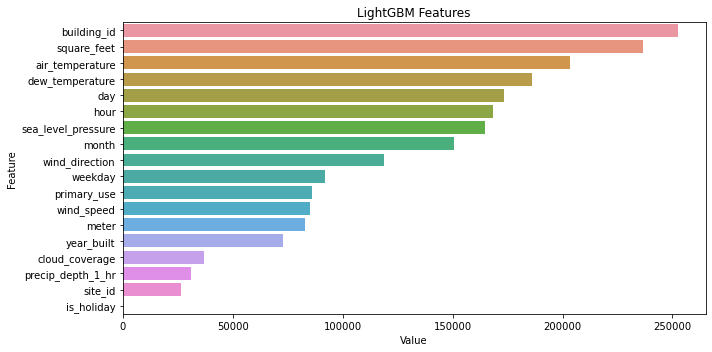

In [41]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), gbm.feature_name()),reverse = True), columns=['Value','Feature'])
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

## Test preparation

In [42]:
test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609


In [43]:
test=features_engineering(test)
test = test.drop('row_id', axis = 1)

### Imputing missing values

In [44]:
test[['year_built','air_temperature','dew_temperature','cloud_coverage','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']]=test[['year_built','air_temperature','dew_temperature','cloud_coverage','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']].astype(np.float32)

cc_fill=test.groupby(['site_id','day','month'])['cloud_coverage'].median().reset_index()
cc_fill.rename(columns={'cloud_coverage':'cc_filler'},inplace=True)
cc_fill['cc_filler'].fillna(method='ffill',inplace=True)
test=test.merge(cc_fill,how='left',on=['site_id','day','month'])
test['cloud_coverage'].fillna(test['cc_filler'],inplace=True)
test.drop(labels=['cc_filler'],axis=1,inplace=True)


wd_fill=test.groupby(['site_id','day','month'])['wind_direction'].median().reset_index()
wd_fill.rename(columns={'wind_direction':'wind_direction_filler'},inplace=True)
test=test.merge(wd_fill,how='left',on=['site_id','day','month'])
test['wind_direction'].fillna(test['wind_direction_filler'],inplace=True)
test.drop(labels=['wind_direction_filler'],axis=1,inplace=True)

at_fill=test.groupby(['site_id','day','month'])['air_temperature'].median().reset_index()
at_fill.rename(columns={'air_temperature':'air_temperature_filler'},inplace=True)
test=test.merge(at_fill,how='left',on=['site_id','day','month'])
test['air_temperature'].fillna(test['air_temperature_filler'],inplace=True)
test.drop(labels=['air_temperature_filler'],axis=1,inplace=True)

dt_fill=test.groupby(['site_id','day','month'])['dew_temperature'].median().reset_index()
dt_fill.rename(columns={'dew_temperature':'dew_temperature_filler'},inplace=True)
test=test.merge(dt_fill,how='left',on=['site_id','day','month'])
test['dew_temperature'].fillna(test['dew_temperature_filler'],inplace=True)
test.drop(labels=['dew_temperature_filler'],axis=1,inplace=True)

ws_fill=test.groupby(['site_id','day','month'])['wind_speed'].median().reset_index()
ws_fill.rename(columns={'wind_speed':'wind_speed_filler'},inplace=True)
test=test.merge(ws_fill,how='left',on=['site_id','day','month'])
test['wind_speed'].fillna(test['wind_speed_filler'],inplace=True)
test.drop(labels=['wind_speed_filler'],axis=1,inplace=True)

slp_fill=test.groupby(['site_id','day','month'])['sea_level_pressure'].median().reset_index()
slp_fill.rename(columns={'sea_level_pressure':'slp_filler'},inplace=True)
slp_fill.fillna(method='ffill',inplace=True)
test=test.merge(slp_fill,how='left',on=['site_id','day','month'])
test['sea_level_pressure'].fillna(test['slp_filler'],inplace=True)
test.drop(labels=['slp_filler'],axis=1,inplace=True)

pd_fill=test.groupby(['site_id','day','month'])['precip_depth_1_hr'].median().reset_index()
pd_fill.rename(columns={'precip_depth_1_hr':'pd_filler'},inplace=True)
pd_fill['pd_filler'].fillna(method='ffill',inplace=True)
test=test.merge(pd_fill,how='left',on=['site_id','day','month'])
test['precip_depth_1_hr'].fillna(test['pd_filler'],inplace=True)
test.drop(labels=['pd_filler'],axis=1,inplace=True)

yb_fill=test.groupby(['site_id','day','month'])['year_built'].median().reset_index()
yb_fill.rename(columns={'year_built':'yb_filler'},inplace=True)
yb_fill['yb_filler'].fillna(method='ffill',inplace=True)
test=test.merge(yb_fill,how='left',on=['site_id','day','month'])
test['year_built'].fillna(test['yb_filler'],inplace=True)
test.drop(labels=['yb_filler'],axis=1,inplace=True)

In [46]:
submission = pd.read_csv('ashrae-energy-prediction/sample_submission.csv')

In [47]:
test_1 = test[:len(test)//3]
y_pred_1 = gbm.predict(test_1, num_iteration=gbm.best_iteration)

del test_1

gc.collect()

70

In [48]:
test_2 = test[len(test)//3:(len(test)*2)//3]
y_pred_2 = gbm.predict(test_2, num_iteration=gbm.best_iteration)

del test_2

gc.collect()

26

In [49]:
test_3 = test[(len(test)*2)//3:]
y_pred_3 = gbm.predict(test_3, num_iteration=gbm.best_iteration)

del test_3

gc.collect()

26

In [50]:
y_pred = np.concatenate([y_pred_1, y_pred_2, y_pred_3], axis=0)

del y_pred_1
del y_pred_2
del y_pred_3

gc.collect()

22

In [51]:
y_pred = np.expm1(y_pred)
fix_predictions(y_pred)
submission['meter_reading'] = y_pred

In [52]:
submission.shape

(41697600, 2)

## Submission

In [53]:
# my_submission = pd.DataFrame({'row_id': submission.row_id, 'meter_reading': y_pred})
# my_submission.to_csv('submi4.csv', index=False)

In [54]:
submission.to_csv('subm4.csv', index=False)

In [59]:
!tar cvfz V2.tar.gz subm4.csv

submi4.csv


In [58]:
# my_submission.to_csv('submission_L5.csv.gz',
#                           index=False,compression='gzip', 
#                           float_format='%.4f', 
#                           chunksize=25000)